In [4]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


Image Transforms

In [5]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


Load Datasets

In [6]:
train_dir = '../data/fer2013/train'
val_dir = '../data/fer2013/test'

train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset = ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

classes = train_dataset.classes
print("Emotion classes:", classes)


Emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Show Sample Images

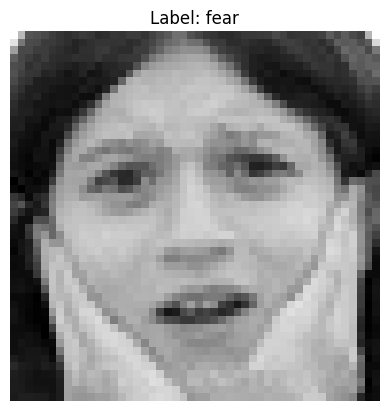

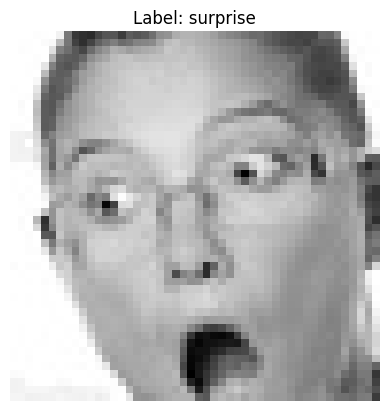

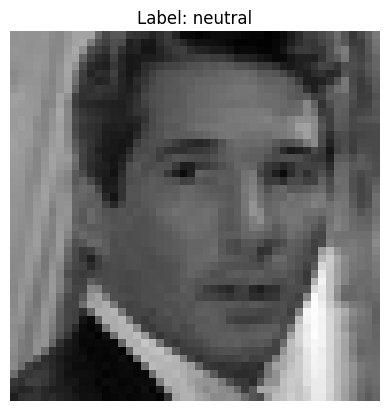

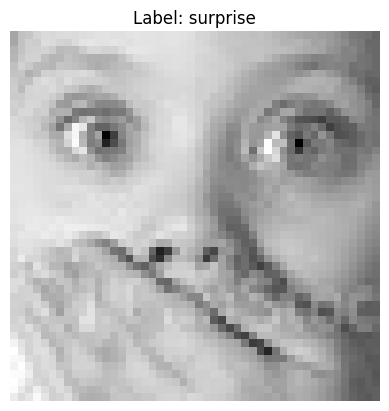

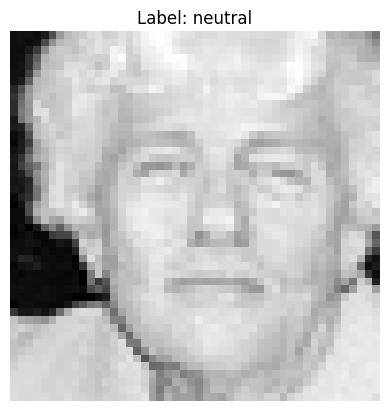

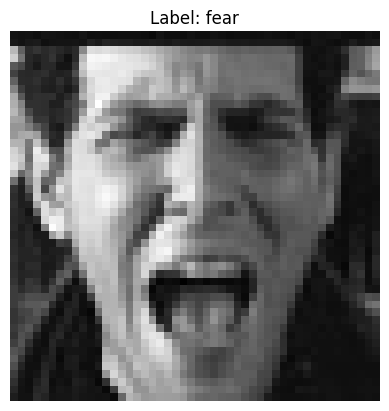

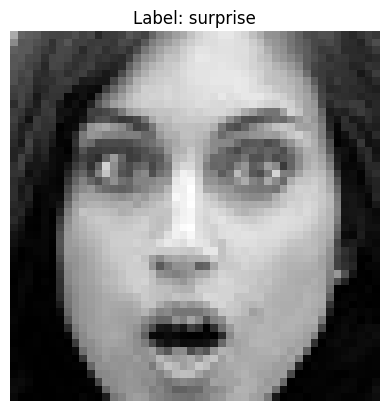

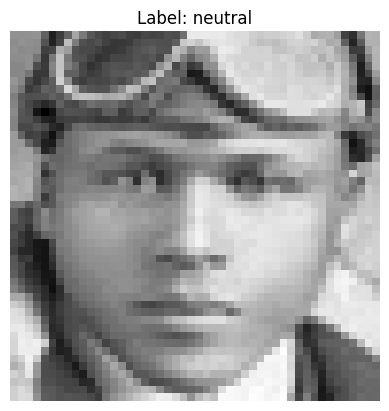

In [7]:
import numpy as np

def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy().squeeze()
    plt.imshow(npimg, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display 8 sample training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
for i in range(8):
    imshow(images[i], f"Label: {classes[labels[i]]}")


Define the CNN Model

In [8]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 12 * 12, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EmotionCNN(num_classes=len(classes)).to(device)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_loss_history = []
val_loss_history = []
val_accuracy_history = []


Training

In [10]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = correct / total
    val_loss_history.append(val_loss)
    val_accuracy_history.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Acc: {accuracy:.2f}")


Epoch 1/10 | Train Loss: 1.6159 | Val Loss: 1.4474 | Acc: 0.45
Epoch 2/10 | Train Loss: 1.4079 | Val Loss: 1.3307 | Acc: 0.49
Epoch 3/10 | Train Loss: 1.2982 | Val Loss: 1.2748 | Acc: 0.51
Epoch 4/10 | Train Loss: 1.2135 | Val Loss: 1.2420 | Acc: 0.52
Epoch 5/10 | Train Loss: 1.1435 | Val Loss: 1.2138 | Acc: 0.53
Epoch 6/10 | Train Loss: 1.0701 | Val Loss: 1.2231 | Acc: 0.54
Epoch 7/10 | Train Loss: 1.0037 | Val Loss: 1.2244 | Acc: 0.55
Epoch 8/10 | Train Loss: 0.9351 | Val Loss: 1.2478 | Acc: 0.54
Epoch 9/10 | Train Loss: 0.8698 | Val Loss: 1.2675 | Acc: 0.55
Epoch 10/10 | Train Loss: 0.8084 | Val Loss: 1.3246 | Acc: 0.55


Plot Training/Validation Curves

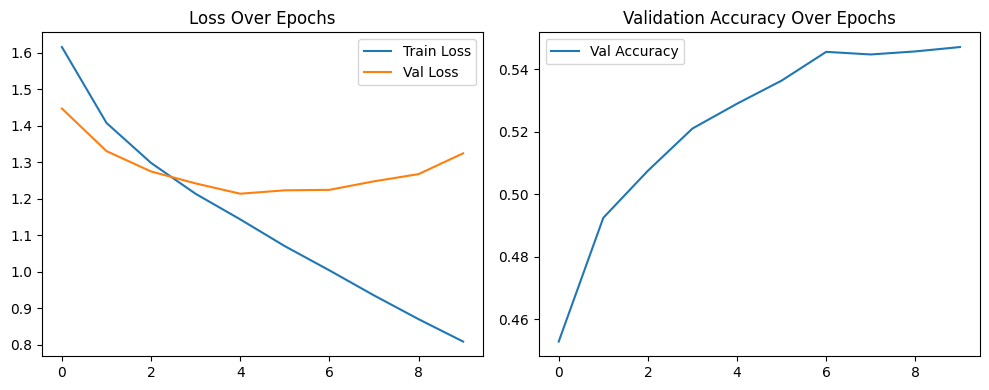

In [11]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1,2,2)
plt.plot(val_accuracy_history, label='Val Accuracy')
plt.legend()
plt.title('Validation Accuracy Over Epochs')

plt.tight_layout()
plt.show()


Confusion Matrix

In [12]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


NameError: name 'confusion_matrix' is not defined

Save the Trained Model

In [ ]:
torch.save(model.state_dict(), '../models/emotion_cnn.pt')
print("Model saved as emotion_cnn.pt")
